### 【 데이터 시각화 】
- 데이터셋 : iris.csv
- 해결문제 : 품종별 시각화에 적합한 특성/속성/컬럼 선정 
- 출력결과 : 선정된 특성을 기반으로 품종 분류한 것 시각화

[1] 모듈 로딩 및 데이터 준비<hr>

In [1]:
## 모듈 로딩
import pandas as pd                     ## 데이터 분석용
import matplotlib.pyplot as plt         ## 데이터 시각화용 

In [2]:
## 데이터 준비
DATA_FILE = '../Data/iris.csv'

In [3]:
## CSV => DataFrame 로딩
irisDF = pd.read_csv(DATA_FILE)

[2] 데이터 확인<hr>

In [4]:
## ----------------------------------------------------------
## [2-1] 기본 데이터 확인 :  head(), info(), describe() 
## -> 컬럼별 결측치 여부
## -> 컬럼별 실제데이터와 요약정보 데이터 타입 일치여부
## -> 컬럼벼 데이터 분포 : 수치형/범주형
## ----------------------------------------------------------
## - 실제 데이터 일부 출력
display(irisDF.head(3))

## - DF 요약 정보 출력
irisDF.info()

## - 컬럼별 통계치/분포 확인 출력
display(irisDF.describe(include='all'))

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal.length  150 non-null    float64
 1   sepal.width   150 non-null    float64
 2   petal.length  150 non-null    float64
 3   petal.width   150 non-null    float64
 4   variety       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


,sepal.length,sepal.width,petal.length,petal.width,variety
count,150.000000,150.000000,150.000000,150.000000,150
unique,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,Setosa
freq,NaN,NaN,NaN,NaN,50
mean,5.843333,3.057333,3.758000,1.199333,NaN
std,0.828066,0.435866,1.765298,0.762238,NaN
min,4.300000,2.000000,1.000000,0.100000,NaN
25%,5.100000,2.800000,1.600000,0.300000,NaN
50%,5.800000,3.000000,4.350000,1.300000,NaN
75%,6.400000,3.300000,5.100000,1.800000,NaN


In [5]:
## --------------------------------------------------------------
## [2-2] 컬럼별 세부 체크 : isna()-> 들어나는 결측치 X
##       -> 각 컬럼별 고유값 검사 진행. 이상한 값이 있는지 체크  
##       -> unique()        : 고유값 종류 / Series에만 제공 메서드
##       -> nunique()       : 고유값 갯수 / Series에만 제공 메서드
##       -> value_counts()  : 값/고유값별로 데이터 수 
## -------------------------------------------------------------
## -> DF의 컬럼명 추출 : DF.columns
for col in irisDF.columns:

    #with open('./iris_unique.txt', mode='a', encoding='utf-8') as F:
    with open(f'./{col}_iris_unique.txt', mode='w', encoding='utf-8') as F:    

        print(f'[{col}]---------{irisDF[col].nunique()}개, {irisDF[col].dtype}', file=F)
        print(f'-> 고유값\n{irisDF[col].unique() }', file=F)
        print(f'-> 고유값별 데이터수\n{irisDF[col].value_counts() }\n', file=F)


In [6]:
## --------------------------------------------------------------
## [2-3] 컬럼별 세부 체크 : duplicated()-> 행/레코드 일치 중복값 체크 
##       ->행 별 중복값 가능한가 여부 결정 후 진행 
## -------------------------------------------------------------
print('중복행/샘플 수 : ', irisDF.duplicated().sum())

irisDF[irisDF.duplicated()]

## => 식물/생물의 경우 동일한 행 존재 가능함! 유지 

중복행/샘플 수 :  1


,sepal.length,sepal.width,petal.length,petal.width,variety
142,5.8,2.7,5.1,1.9,Virginica


In [7]:
## --------------------------------------------------------------
## [2-4] 분류 문제로 타겟 컬럼의 균형 데이터 여부 체크 
##       -> 품종별 데이터 개수 체크 : value_counts()
## -------------------------------------------------------------
varietySR = irisDF.variety.value_counts()

## Serie => to_XXX() : XXX 형태로 변환 메서드
## -> varietySR.to_frame() => DataFrame
## -> varietySR.to_list()  => List
print('품종별 데이터 수 : ', varietySR.to_dict() )

## => 균형 데이터 

품종별 데이터 수 :  {'Setosa': 50, 'Versicolor': 50, 'Virginica': 50}


In [8]:
## ------------------------------------------------------------------------
## [2-5] 컬럼별 이상치 데이터 검사 진행 
##       -> IQR 사용
## ------------------------------------------------------------------------

## ------------------------------------------------------------------------
## 함수기능 : IQR기반 이상치 여부 검사 후 결과 반환
## 함수이름 : iqr_outlier_mask
## 매개변수 : sr            <- Series 인스턴스
##           k=1.5         <- 임계값
## 결과반환 : 이상치 True, 정상 False로 된 Series 반환
## ------------------------------------------------------------------------
def iqr_outlier_mask(sr, k= 1.5):
    # 오름차순 정렬 후 중앙값, 중앙값 왼쪽부분 중앙값, 오른쪽 부분 중앙값 추출 
    q1, q3 = sr.quantile([0.25, 0.75])
    iqr    = q3 - q1
    lower, upper = q1 - k * iqr, q3 + k * iqr
    return (sr < lower) | (sr > upper)


## ------------------------------------------------------------------------
## 함수기능 : 이상치 행 추출해서 해당 정보를 반환
## 함수이름 : get_outlier_records
## 매개변수 : dataDF
##           numeric_cols
##           k 
## 결과반환 : 이상치 행 추출해서 dict 반환
##           {"column":컬럼명, "index":행인덱스, "value":데이터}
## ------------------------------------------------------------------------
def get_outlier_records(dataDF, numeric_cols, k = 1.5):
    ## 이상치 행/레코드 정보 저장 
    outlier_records = []

    ## 컬럼별 이상치 추출 및 정보 저장
    for col in numeric_cols:
        # 컬럼별 이상치 검사용 마스크
        colSR = dataDF[col]
        mask  = iqr_outlier_mask(colSR, k=k)
        
        # SR에서 1개라도 True면 True를 반환 : any() <-> all()
        if mask.any():
            for idx in colSR[mask].index.to_list():
                recordDict = {"column": col, 
                              "index": int(idx), 
                              "value": float(colSR.loc[idx])}
                outlier_records.append(recordDict)

    return outlier_records

## ------------------------------------------------------------------------
## 함수기능 : 컬럼별 이상치 검사 후 시각화 
## 함수이름 : visualize_outliers
## 매개변수 : dataDF
##           numeric_cols
##           k=1.5     민감도. 데이터의 분포를 고려해 조절
##                     분산이 큰 데이터: K를 크게 (예: 2.0~3.0)
##                      → 너무 많은 정상값이 이상치로 잡히는 걸 방지
##
##                     값이 좁은 구간에 밀집된 데이터: K를 작게 (예: 1.0~1.2)
##                      → 미세한 튀는 점도 포착 가능
## 결과반환 : 직접 그래프 출력. 없음
## ------------------------------------------------------------------------
def visualize_outliers(dataDF, numeric_cols, k = 1.5):
    for col in numeric_cols:
        ## - 컬럼별 이상치 검사 
        colSR = irisDF[col]
        mask  = iqr_outlier_mask(colSR, k=1.5)

        ## - 시각화 그래프
        plt.figure(figsize=(7, 4))
        # 모든 데이터 산점도 
        plt.scatter(colSR.index, colSR, label=col)
        
        # 이상치 데이터만 추출해서 산점도 출력
        out_idx = mask[mask].index
        plt.scatter(out_idx, colSR.loc[out_idx], marker='x', s=100, label='outlier')

        # 그래프 공통
        plt.title(f"{col} — index vs value (IQR)")
        plt.xlabel("index")
        plt.ylabel(col)
        plt.legend()
        plt.tight_layout()
        plt.show()

## ------------------------------------------------------------------------
## 함수기능 : 이상치 치환 후 반환 
## 함수이름 : cap_iqr
## 매개변수 : s      Series
##           k=1.5  임계값
## 결과반환 : 하한값/상한값으로 이상치 치환 후 반환 
## ------------------------------------------------------------------------
## => 해당 값은 생물학적으로 가능한가? 
def cap_iqr(s, k=1.5):
    # 4분위수 계산
    q1, q3 = s.quantile([0.25, 0.75])

    # 사분위수범위
    iqr    = q3 - q1

    # 하한값/상한값
    lo, hi = q1 - k*iqr, q3 + k*iqr

    # 치환 후 반환 
    return s.clip(lower=lo, upper=hi)



numeric_cols =>  ['sepal.length', 'sepal.width', 'petal.length', 'petal.width']


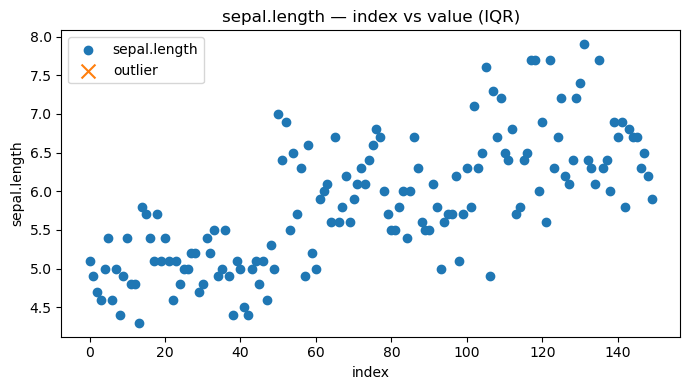

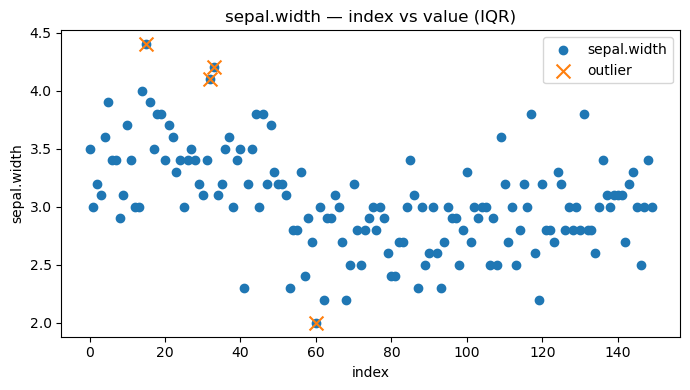

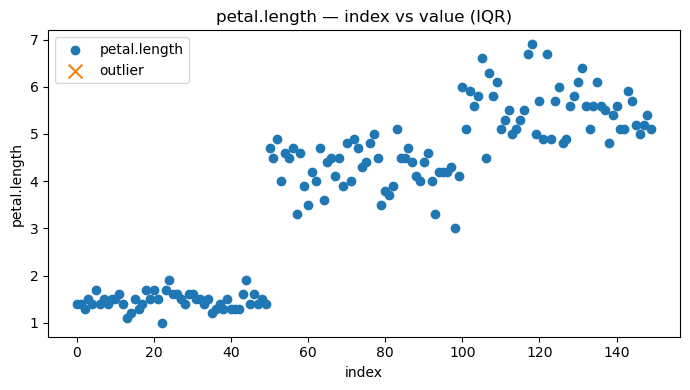

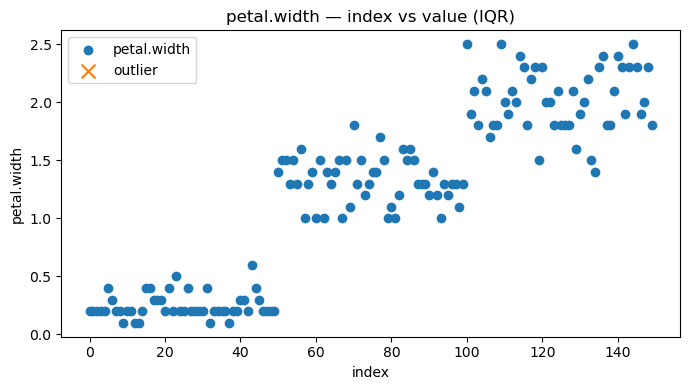

,column,index,value
0,sepal.width,15,4.4
1,sepal.width,32,4.1
2,sepal.width,33,4.2
3,sepal.width,60,2.0


In [9]:
##- 수치형 컬럼만 추출
##- select_dtypes() : DF에 특정 타입의 컬럼 추출 반환
numeric_cols = irisDF.select_dtypes(include=['number']).columns.to_list()
print('numeric_cols => ', numeric_cols)


#- 컬럼별 이상치 & 일반 데이터 시각화 
K = 1.5  
visualize_outliers(irisDF, numeric_cols, k=K)


#- 이상치 행만 추출 
outlier_records = get_outlier_records(irisDF, numeric_cols, k=K)
summary_df = pd.DataFrame(outlier_records, 
                          columns=["column", "index", "value"])
display(summary_df)


In [10]:
## -------------------------------------------------------------------------------------
## -> 이상치를 버려야 하는 경우
## -------------------------------------------------------------------------------------
## -- 입력 오류	                     예: ‘길이(cm)’에 400이 들어갔을 때 단위 실수
## -- 측정 센서 오작동 일시적 오류로 비정상 수치
## -- 비정상 조건에서 수집된 데이터	    예: 장비 점검 시의 센서 로그
## -- 통계 모델(평균 중심)	선형회귀, PCA 등 평균/분산 기반 모델은 이상치에 민감하므로 제거 유리
## -------------------------------------------------------------------------------------

## -------------------------------------------------------------------------------------
## -> 이상치를 유지해야 하는 경우
## -------------------------------------------------------------------------------------
## -- 데이터 자체가 다양한 분포를 가짐	 예: 꽃잎 길이의 자연적 변동, 사람의 키 등
## -- 이상치가 중요한 현상	            예: 센서 이상 감지, 이상 거래 탐지, 불량 탐지 등
## -- 로버스트 모델 사용 시	트리계열, Huber 회귀, RobustScaler 등은 이상치에 덜 민감
## -------------------------------------------------------------------------------------

## 식물/생물 데이터에는 다양한 값 존재 가능함. 이상치 치환
irisDF['sepal.width'] = cap_iqr(irisDF['sepal.width'])


In [11]:
## ------------------------------------------------------------------------
## [2-6] 타겟 컬럼과 컬럼들의 상관관계성 검사
##       -> corr()  메서드 : 상관계수 수치화
##       -> scatter 시각화 : 시각화 
## ------------------------------------------------------------------------
## 상관계수
## ------------------------------------------------------------------------
## variety => str/object => corr() X  >>>>> 정수 변환 

## - replace() 경고 
pd.set_option('future.no_silent_downcasting', True)

## - 하드코딩
irisDF.variety.replace({'Setosa':0, 'Versicolor':1, 'Virginica':2})

## - DF 복사본 
irisDF2=irisDF.copy()

## - 고유값 리스트로 추출 
vars = irisDF2.variety.unique().tolist()
irisDF2.variety = irisDF2.variety.replace( dict( zip( vars, range(len(vars)) )  )  )

## - variety와 다른 컬럼들의 상관계수 계산
corrSR = irisDF2.corr()['variety']


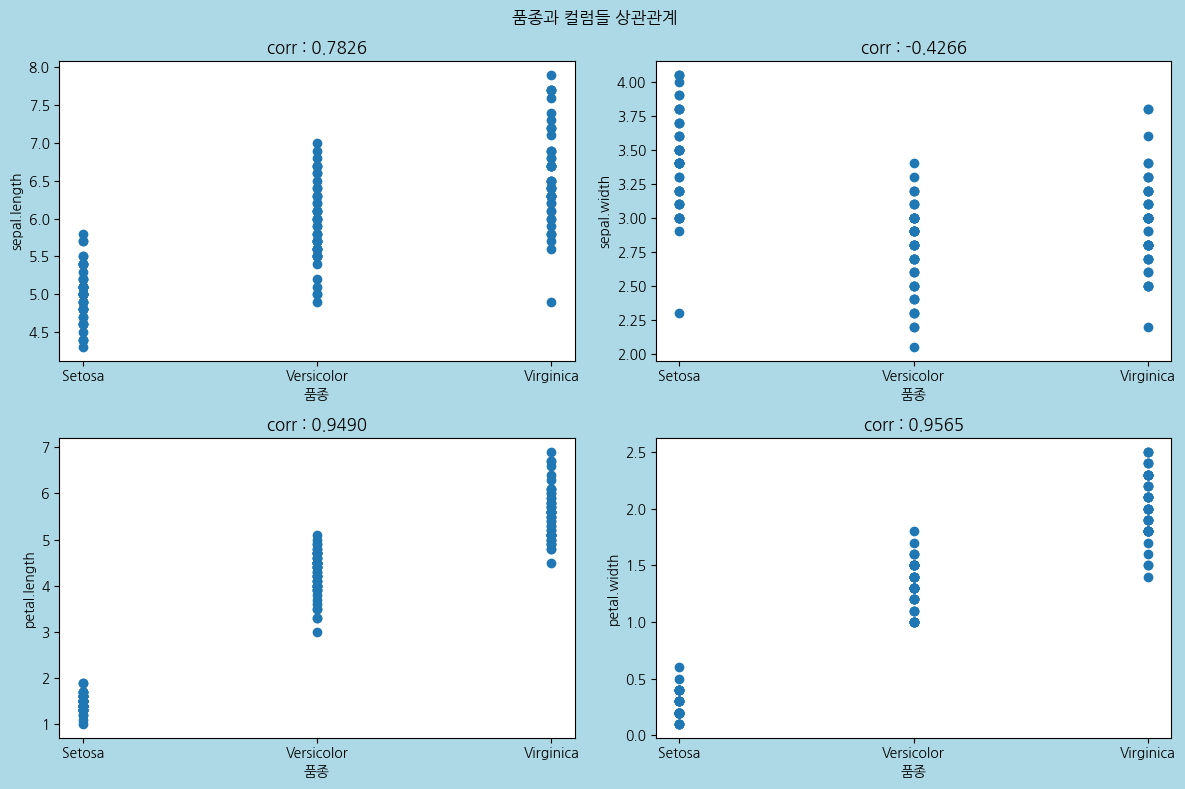

In [12]:
## ------------------------------------------------------------------------
## 시각화 : 여러개 1개 figure에 출력. 1행 4열 또는 2행 2열
## ------------------------------------------------------------------------
## 방법1] plt.subplot() 
## ------------------------------------------------------------- 
import koreanize_matplotlib 

plt.figure(figsize=(12,8), facecolor='lightblue')
for idx in range(4):
    plt.subplot(2,2,idx+1)
    plt.scatter(irisDF.variety, irisDF[irisDF.columns[idx]] )
    plt.xlabel('품종')
    plt.ylabel(f'{irisDF.columns[idx]}')
    plt.title(f'corr : {corrSR[irisDF.columns[idx]]:.4f}')

plt.suptitle("품종과 컬럼들 상관관계")
plt.tight_layout()
plt.show()


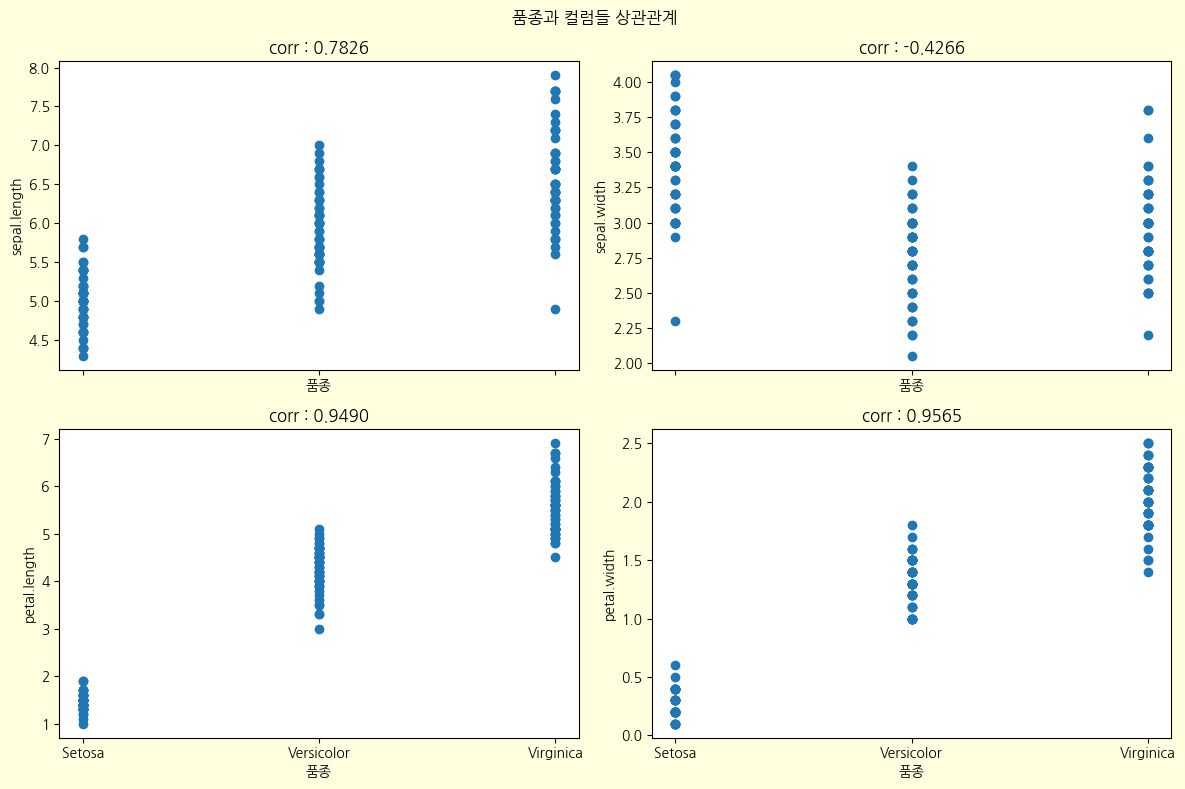

In [18]:
## ------------------------------------------------------------- 
## 방법2] plt.subplots(행,열) -> figure객체, axes 객체 리스트 반환
## ------------------------------------------------------------- 
fig, axes = plt.subplots(2,2, sharex=True, figsize=(12, 8))
fig.set_facecolor('lightyellow')

## 2D => 1D List
axes = axes.flatten()

for ax, col in zip(axes, irisDF.columns[:-1]):    ## (axes0, 컬럼명0), (axes1, 컬럼명1), ..., (axes3, 컬럼명3)
    ax.scatter(irisDF.variety, irisDF[col] )
    ax.set_xlabel('품종')
    ax.set_ylabel(f'{col}')
    ax.set_title(f'corr : {corrSR[col]:.4f}')

plt.suptitle("품종과 컬럼들 상관관계")
plt.tight_layout()
plt.show()

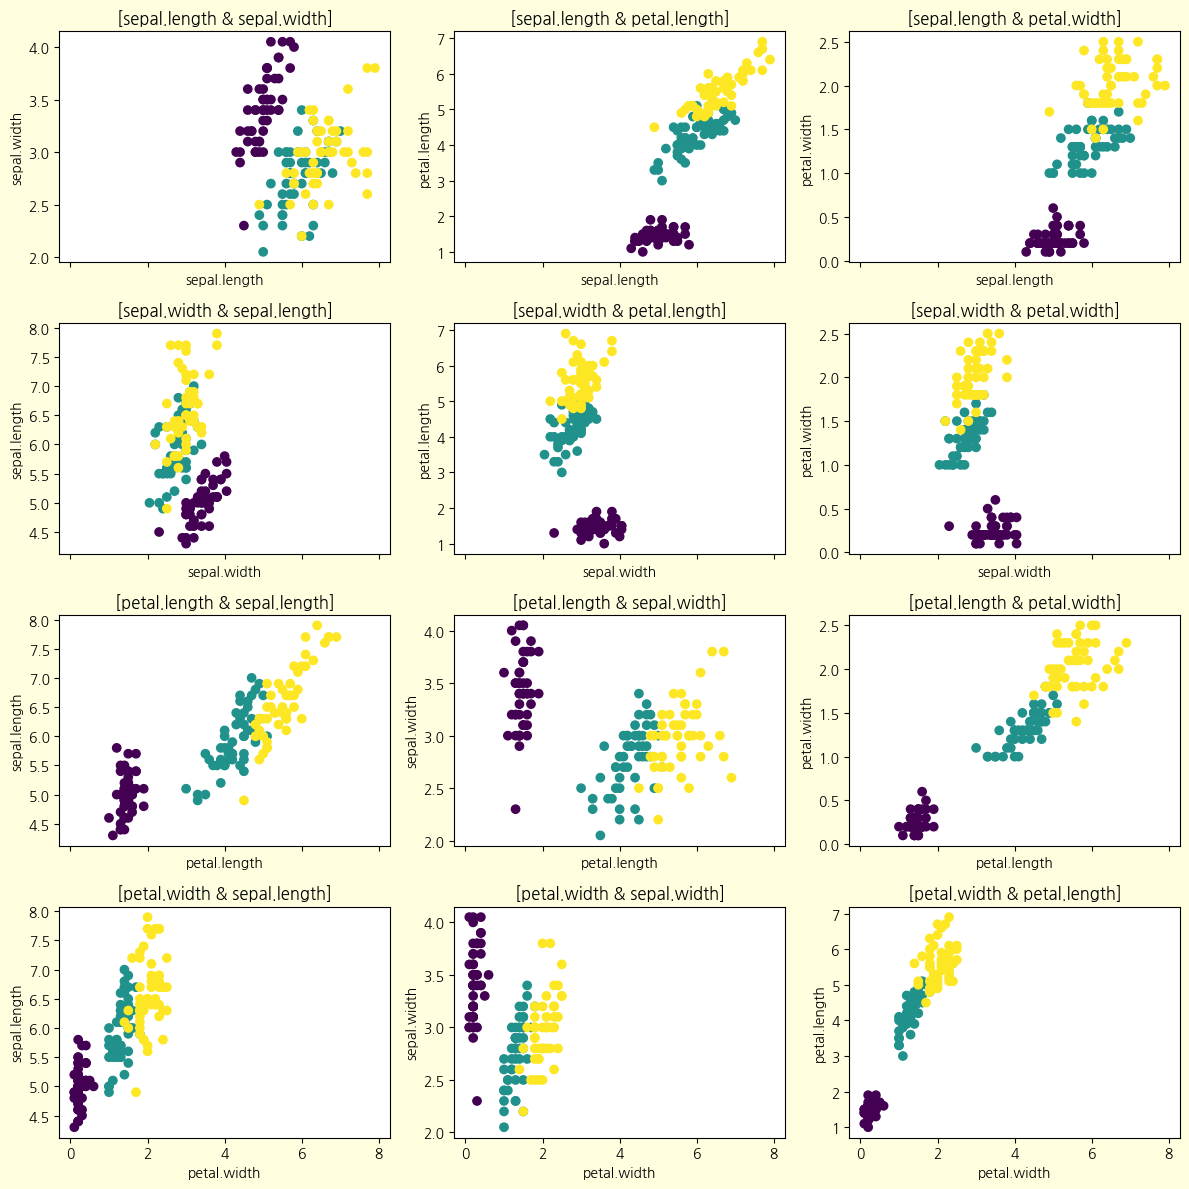

In [ ]:
## ------------------------------------------------------------- 
## 방법2] plt.subplots(행,열) -> figure객체, axes 리스트 반환
## ------------------------------------------------------------- 
NROW , NCOL = 4, 3
fig, axes = plt.subplots(NROW, NCOL, sharex=True, figsize=(12, 12))
fig.set_facecolor('lightyellow')

NCOLS = irisDF.columns[:-1].shape[0]
for rIdx in range(NROW):
    cols = [ idx for idx in range(NCOLS) if rIdx != idx]
    for cIdx  in range(NCOL):
        xCol, yCol = irisDF.columns[rIdx], irisDF.columns[cols[cIdx]]
        ## => c 매개변수 : 품종별 다른 색상 
        axes[rIdx,cIdx].scatter(irisDF[xCol],  irisDF[yCol], c=irisDF2.variety)
        axes[rIdx,cIdx].set_xlabel(f'{xCol}')
        axes[rIdx,cIdx].set_ylabel(f'{yCol}')
        axes[rIdx,cIdx].set_title(f'[{xCol} & {yCol}]')
    
# plt.suptitle("품종과 컬럼들 상관관계")
plt.tight_layout()
plt.show()